## Quality Control (QC)

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import rc_context
import scanpy as sc
import scipy.io
import os
import math
import gseapy as gp
from gseapy.plot import barplot, dotplot, gseaplot
from gseapy.scipalette import SciPalette
from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap 
import celltypist
import seaborn as sns
from pathlib import Path
%matplotlib inline


In [7]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
sc.settings.set_figure_params(dpi=100, dpi_save=300, figsize=(5, 5))
plt.set_cmap('viridis')


### scrublet

In [6]:
output_file = ''
input_dir = ''
os.chdir(input_dir)

counts_matrix = scipy.io.mmread(input_dir + '/matrix.mtx').T.tocsc()
genes = np.array(scr.load_genes(input_dir + '/features.tsv', delimiter='\t', column=1))
out_df = pd.read_csv(input_dir + '/barcodes.tsv', header = None, index_col=None, names=['barcode'])

print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))
print('Number of genes in gene list: {}'.format(len(genes)))

In [7]:
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.06)

In [8]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, min_cells=3, min_gene_variability_pctl=85, n_prin_comps=30)

In [9]:
scrub.call_doublets(threshold=0.25)

In [10]:
scrub.plot_histogram()
plt.savefig(output_file,dpi=1000)

In [11]:
out_df['doublet_scores'] = doublet_scores
out_df['predicted_doublets'] = predicted_doublets
out_df.to_csv(input_dir + '/doublet.txt', index=False,header=True)

### standardized and concat

... storing 'feature_types' as categorical


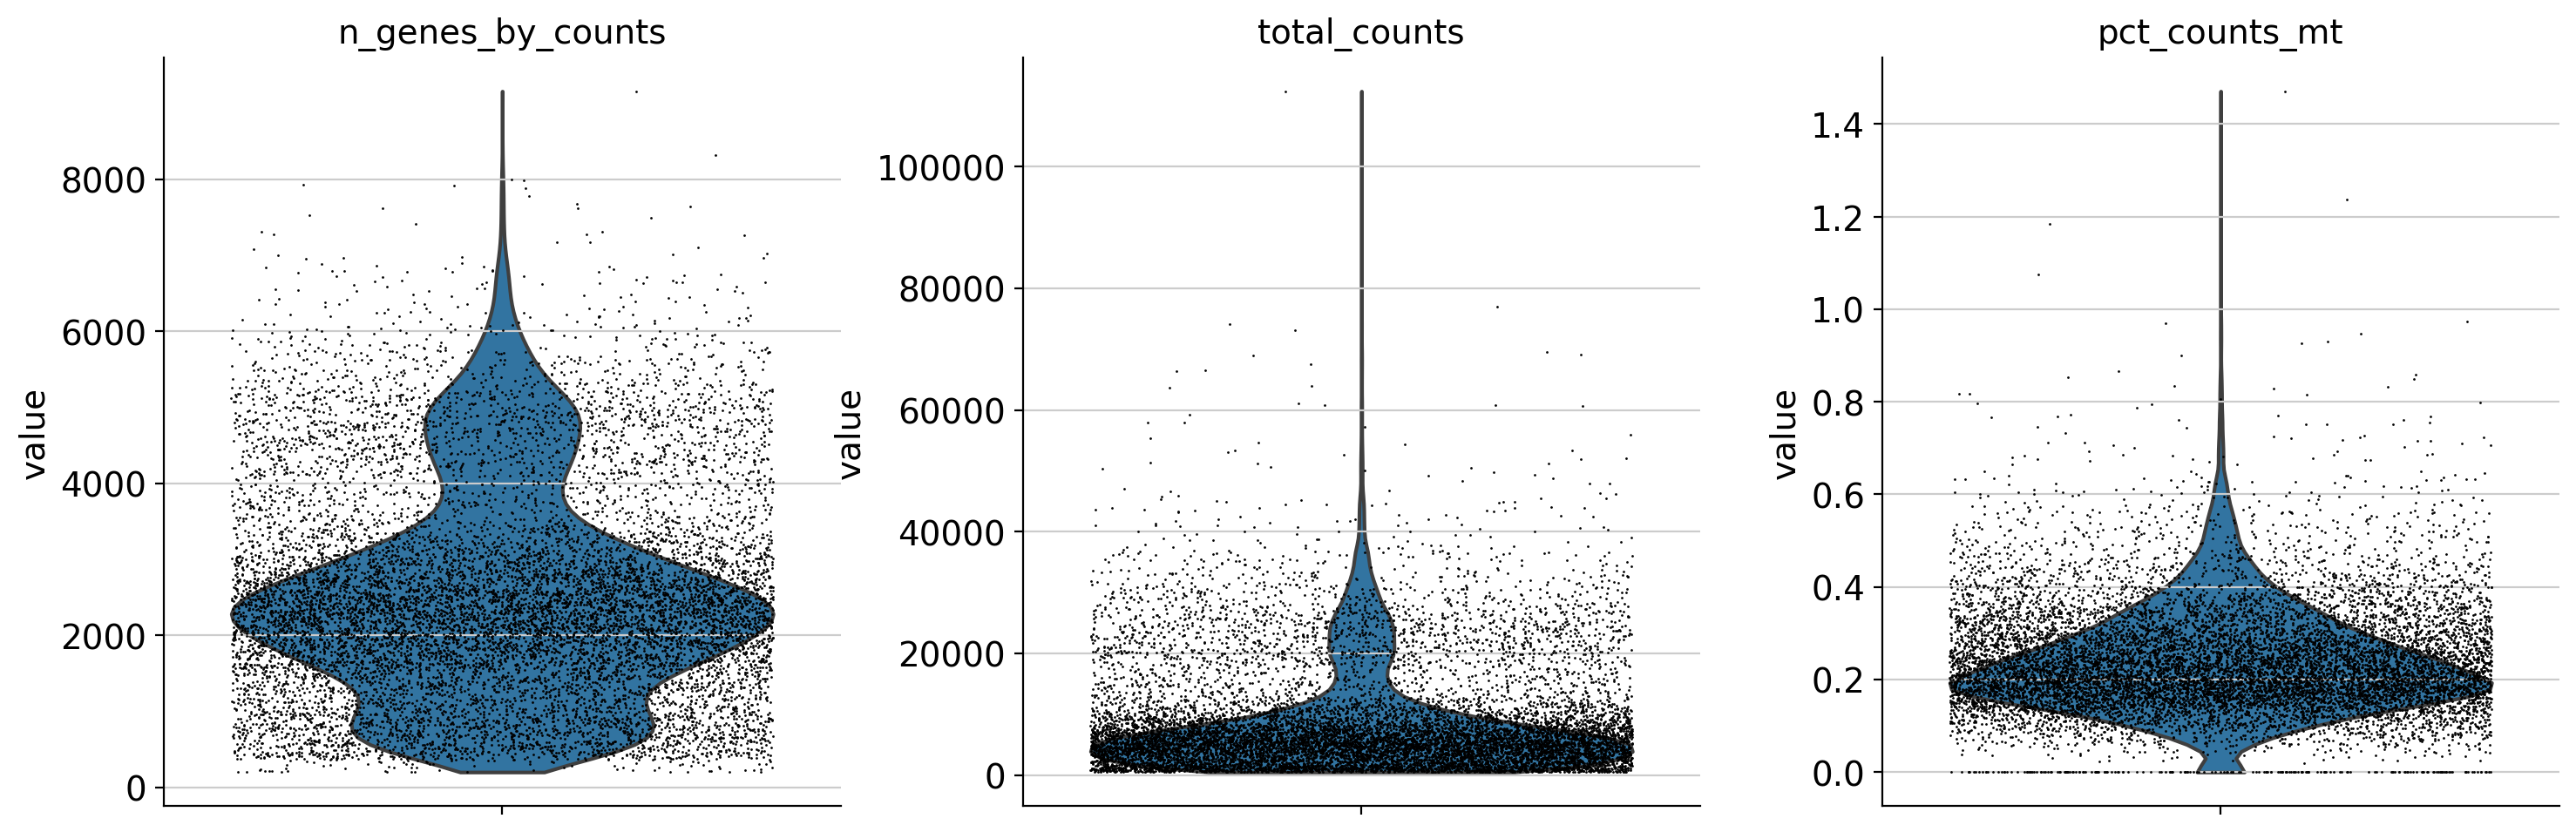

... storing 'feature_types' as categorical


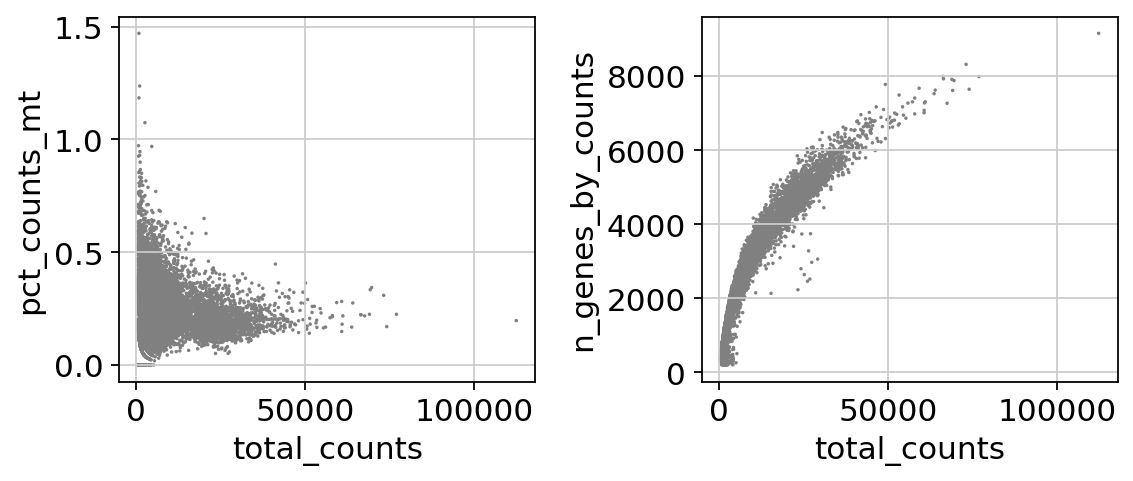

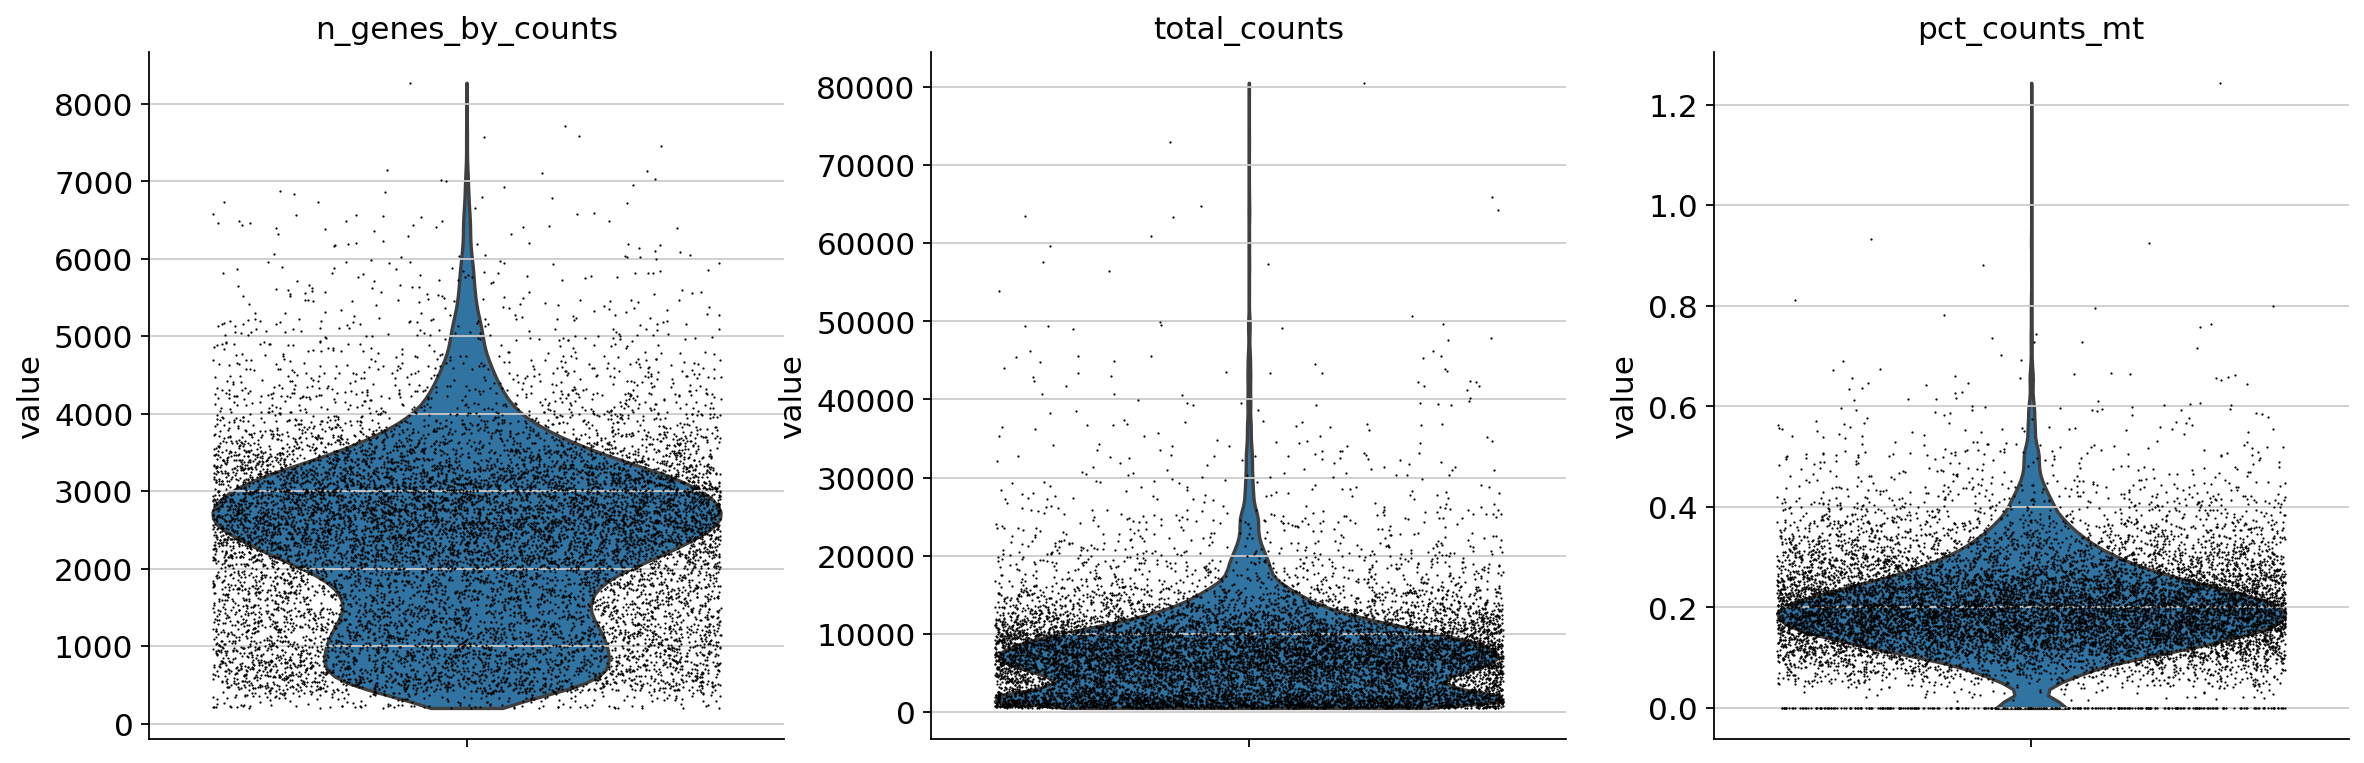

... storing 'feature_types' as categorical


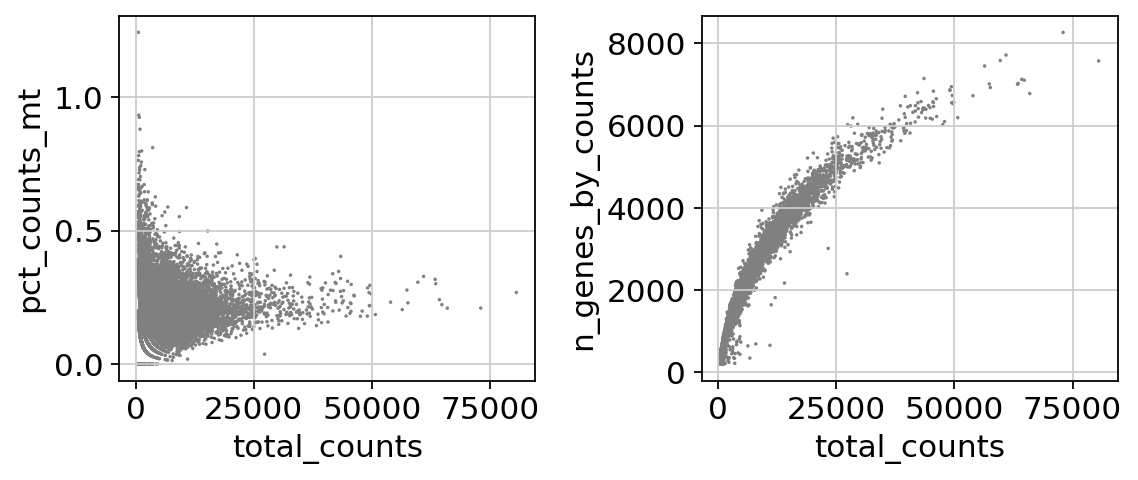

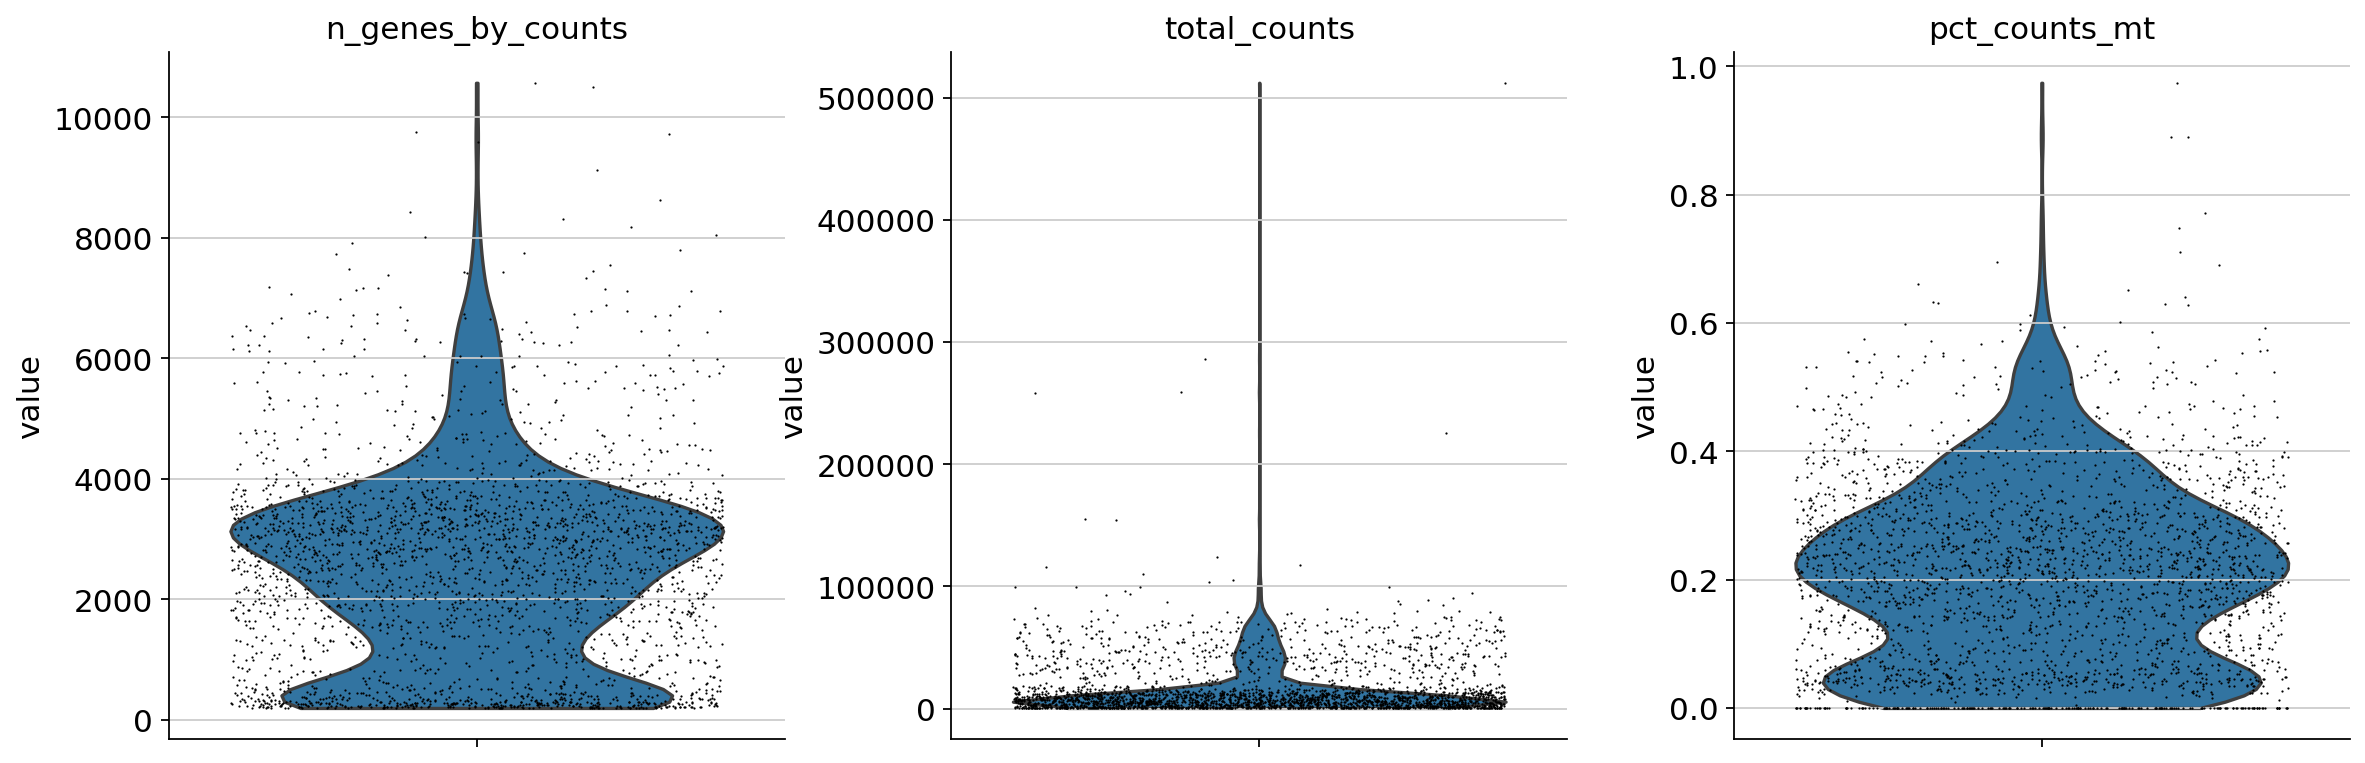

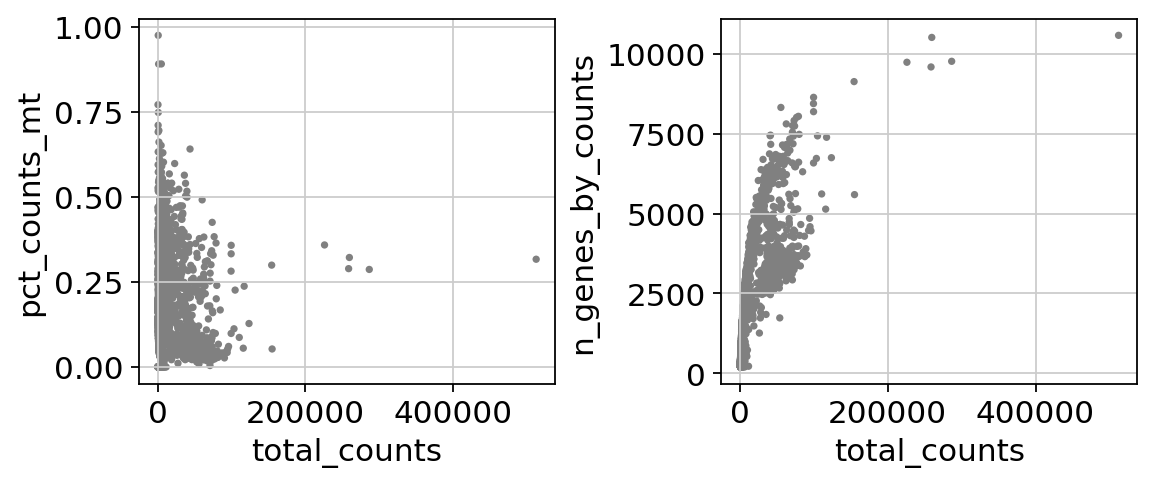

In [12]:
PATH='' 
ap={}
sample=['DUR_JE','SS_JE','JH_JE']

for i in sample:
    ap[f'{i}']=sc.read_10x_mtx(PATH+f'{i}')
    ap[f'{i}'].var_names_make_unique
    scrublets=pd.read_csv(PATH+f'{i}'+'/doublet.txt',index_col='barcode')
    ap[f'{i}'].obs['doublet_scores']=scrublets['doublet_scores']
    ap[f'{i}'].obs['predicted_doublets']=scrublets['predicted_doublets']
    x=['{}',f'{i}']
    ap[f'{i}'].obs.index=ap[f'{i}'].obs.index.map('_'.join(x).format)
    
    sc.pp.filter_cells(ap[f'{i}'], min_genes=200)
    sc.pp.filter_genes(ap[f'{i}'], min_cells=3)
    ap[f'{i}'].var['mt'] = ap[f'{i}'].var_names.str.startswith('MT')
    sc.pp.calculate_qc_metrics(ap[f'{i}'], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    
    
    sc.pl.violin(ap[f'{i}'], ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)
    
    sc.settings.set_figure_params(dpi_save=300)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    sc.pl.scatter(ap[f'{i}'], x='total_counts', y='pct_counts_mt', ax=ax[0], show=False)
    sc.pl.scatter(ap[f'{i}'], x='total_counts', y='n_genes_by_counts', ax=ax[1], show=False)
    plt.subplots_adjust(wspace=.4)
    
    ap[f'{i}'] = ap[f'{i}'][ap[f'{i}'].obs.n_genes_by_counts < 7500, :]
    ap[f'{i}'] = ap[f'{i}'][ap[f'{i}'].obs.n_genes_by_counts > 200, :]
    ap[f'{i}'] = ap[f'{i}'][ap[f'{i}'].obs.pct_counts_mt < 0.5, :]

In [17]:
adata=sc.concat(ap.values(),keys=ap.keys(),label='PROJECT')
adata

AnnData object with n_obs × n_vars = 26246 × 15485
    obs: 'doublet_scores', 'predicted_doublets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'BATCH', 'BREED', 'FEATURE', 'PROJECT'

In [18]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)  

In [19]:
sc.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=3,min_disp=0.5,batch_key='BATCH')
print("Highly variable genes intersection: %d"%sum(adata.var.highly_variable_intersection))
print("Number of batches where gene is variable:")
print(adata.var.highly_variable_nbatches.value_counts())
var_genes_batch = adata.var.highly_variable_nbatches > 0 

... storing 'BATCH' as categorical
... storing 'BREED' as categorical
... storing 'FEATURE' as categorical


Highly variable genes intersection: 941
Number of batches where gene is variable:
highly_variable_nbatches
0    10265
1     3045
2     1234
3      941
Name: count, dtype: int64


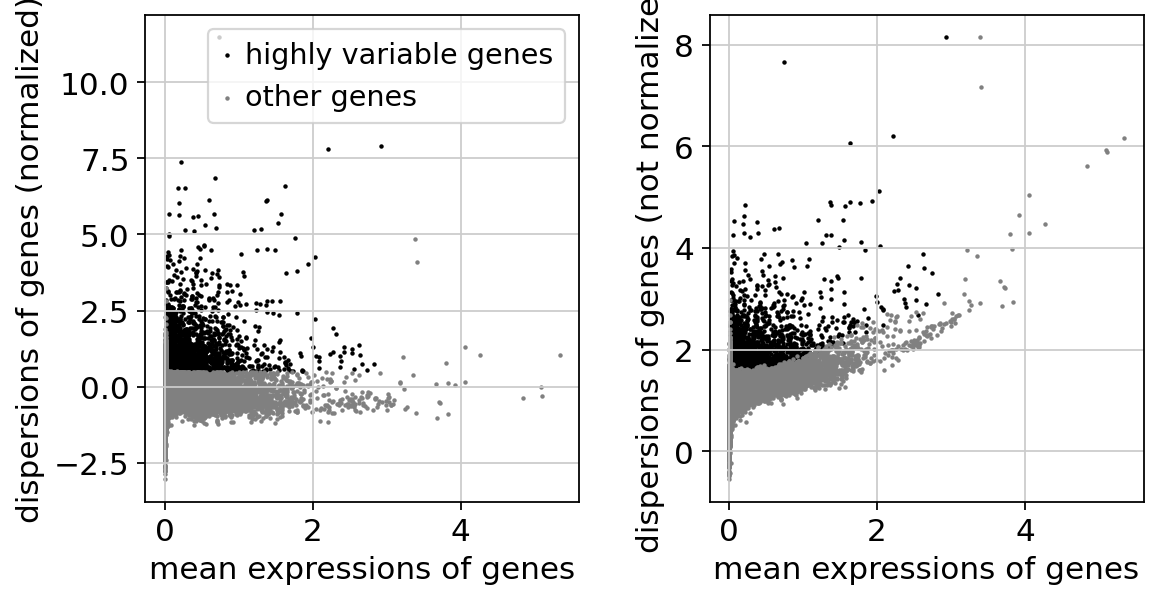

In [20]:
sc.pl.highly_variable_genes(adata)

In [21]:
var_select = adata.var.highly_variable_nbatches > 1
var_genes = var_select.index[var_select]
len(var_genes)

2175

In [22]:
adata.raw = adata
adata = adata[:,adata.var.highly_variable]

In [23]:
adata

View of AnnData object with n_obs × n_vars = 26246 × 2438
    obs: 'doublet_scores', 'predicted_doublets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'BATCH', 'BREED', 'FEATURE', 'PROJECT'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'